In [9]:
import os
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as np

from amygdala_spiking.data import load_bids_subject, epoch_sig
from amygdala_spiking.preproc import preprocess

from neurodsp.spectral import compute_spectrum
from fooof import FOOOFGroup

### Load Data

In [2]:
# Load bids data
bids_dir = os.path.join(os.getcwd(), 'data_bids')
raw = load_bids_subject('01', bids_dir)

# Extract data from MNE raw object
sigs, times = raw.get_data(return_times=True)

# Channel keys and epoched sig values
sigs_ch = {ch_name:epoch_sig(sig) for sig, ch_name in zip(sigs, raw.ch_names)}

fs = raw.info['sfreq']
epoch_types = raw.annotations.description

sub_dict = {'sigs': sigs_ch, 'epoch_types': epoch_types, 'times': times, 'fs': fs}

Extracting parameters from /home/rph/Projects/amygdala_spiking/data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_ieeg.vhdr...
Setting channel info structure...
Reading events from /home/rph/Projects/amygdala_spiking/data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_events.tsv.
Reading channel info from /home/rph/Projects/amygdala_spiking/data_bids/sub-01/ses-01/ieeg/sub-01_ses-01_task-jokeit_run-01_channels.tsv.


### Low-pass Filter

In [3]:
# Bandpass filter
preproc_dict = preprocess(sub_dict, pass_type='lowpass', f_range=100)

### Compute Spectra

In [4]:
freqs, powers = compute_spectrum(sigs_ch['mmAL1'], fs, f_range=(0, 100))

### Define Parameter Grid

Defines combinations of peak widths limits, max number of peaks, and aperiodic mode. The gridsearch may take a few minutes to complete.

In [5]:
# Set range for peak_width_limits
lower_width = 0.5
upper_width = 12

peak_width_limits = []

limits = np.linspace(lower_width, upper_width, 10).round(2)
for idx, lb in enumerate(limits[:-1]):
    for ub in limits[idx+1:]:
        peak_width_limits.append([lb, ub])

# Set range for max_n_peaks
max_n_peaks = np.arange(1, 10)

# Set range for aperiodic_mode
aperiodic_mode = [0, 1]

# Combinations
n_params = len(peak_width_limits) * len(max_n_peaks) * len(aperiodic_mode)

param_grid = np.zeros((n_params, 4))
idx = 0
for limits in peak_width_limits:
    for n_peaks in max_n_peaks:
        for mode in aperiodic_mode:
            
            param_grid[idx][0] = limits[0]
            param_grid[idx][1] = limits[1]
            param_grid[idx][2] = n_peaks
            param_grid[idx][3] = mode
            
            idx += 1

In [7]:
# Iterate over grid, refitting specparam, and 
#   storing r-squared values.
rsqs = np.zeros((len(param_grid), 17))

for idx, params in tqdm(enumerate(param_grid)):
    
    fit_args = {
        'peak_width_limits': (params[0], params[1]),
        'max_n_peaks': params[2],
        'aperiodic_mode': 'fixed' if params[3] == 0 else 'knee',
        'verbose': False
    }
    
    fg = FOOOFGroup(**fit_args)

    fg.fit(freqs, powers, n_jobs=-1)
    
    rsqs[idx] = fg.get_params('r_squared')

0it [00:00, ?it/s]

### Plot Results

In [10]:
rsqs_avg = rsqs.mean(axis=1)
plt.rcParams.update({'font.size': 18})

def plt_performance(rsqs_avg, param, ylab):
    fig = plt.figure(figsize=(10, 7.5))
    plt.scatter(rsqs_avg, param)
    plt.xlabel('R-Squared')
    plt.ylabel(ylab)
    plt.show()

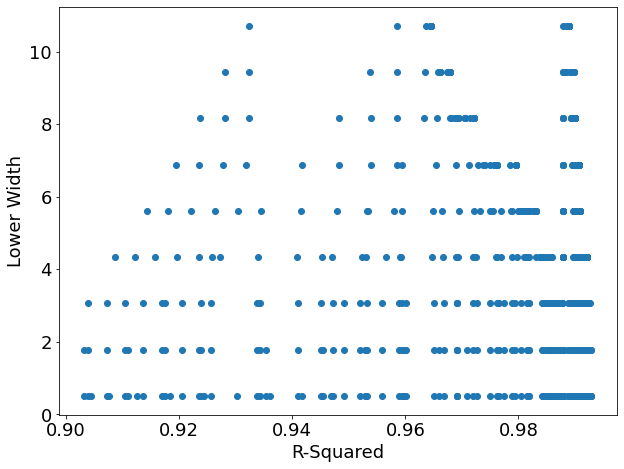

In [11]:
plt_performance(rsqs_avg, param_grid[:, 0], 'Lower Width')

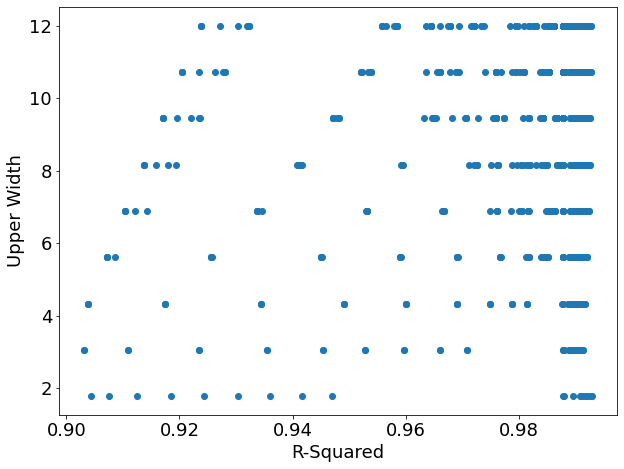

In [12]:
plt_performance(rsqs_avg, param_grid[:, 1], 'Upper Width')

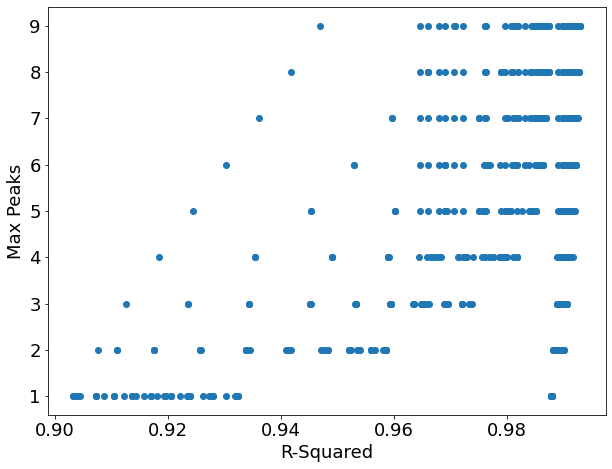

In [13]:
plt_performance(rsqs_avg, param_grid[:, 2], 'Max Peaks')

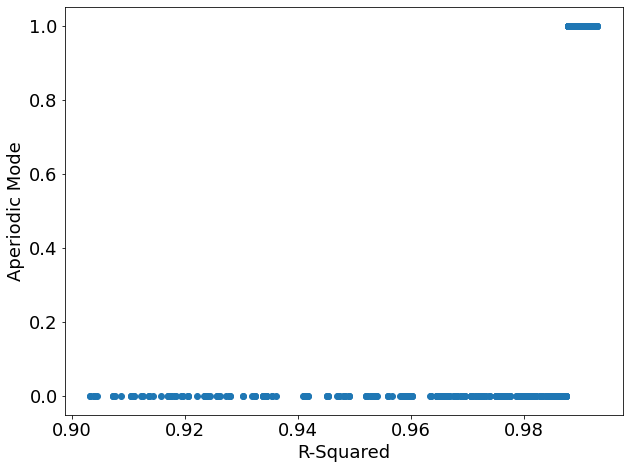

In [14]:
# 0 = fixed
# 1 = knee
plt_performance(rsqs_avg, param_grid[:, 3], 'Aperiodic Mode')